# Find matching fragment pairs

Conditions
- dummy atoms have complementary subpockets
- dummy atoms have identical BRICS environment
- dummy atoms have same bond type

## 1. Load Fragment library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path

import pandas as pd
#import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Lipinski, PandasTools

from kinfraglib import utils
from kinfraglib import filters

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
# Path to data
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../../data'

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [6]:
pd.concat(fragment_library).reset_index(drop=True).shape

(7486, 15)

## 2. Apply Filters to fragment library

### 2.1. Prefilters

In [7]:
fragment_library_pre_filtered = filters.prefilters.pre_filters(
    fragment_library)

In [8]:
fragment_library_original = fragment_library.copy()
fragment_library = fragment_library_pre_filtered.copy()

### 2.2. unwanted substructures

In [9]:
pains_dict = filters.pains.get_pains(fragment_library)

In [10]:
fragment_library_filtered = pains_dict["fragment_library"]
pains_df = pains_dict["pains"]

In [11]:
HERE = Path(_dh[-1])
DATA =  HERE / '../../../Brenk'

In [12]:
brenk_dict = filters.unwanted_substructures.get_brenk(fragment_library_filtered, DATA)

Number of unwanted substructures in Brenk et al. collection: 104


In [13]:
fragment_library_filtered =  brenk_dict['fragment_library']
brenk_structs = brenk_dict['brenk']

### 2.3. Drug likeness

In [14]:
druglikeness_dict = filters.ruleofthree.get_ro3_frags(fragment_library_filtered)
fragment_library_filtered = druglikeness_dict["fragment_library"]
ro3_vals = druglikeness_dict["ro3"]

In [15]:
res_qed = filters.qed.get_qed(fragment_library_filtered)
fragment_library_filtered = res_qed["fragment_library"]
qed_vals = res_qed["qed"]

### 2.4. Synthesizability

In [16]:
synthesizability_dict = filters.building_blocks.check_building_blocks(
    fragment_library_filtered,
    str(str(PATH_DATA)+'/filters/DataWarrior/Enamine_Building_Blocks.sdf'))

In [17]:
fragment_library_filtered = synthesizability_dict['fragment_library']

In [18]:
d_sybas = filters.syba.calc_syba(
    fragment_library_filtered,
    cutoff=0)

In [19]:
fragment_library_filtered = d_sybas['fragment_library']
sybascore = d_sybas['sybas']

### 2.5. save only fragments passing all filters

In [20]:
fragment_library_filtered = filters.analysis.number_of_accepted(
    fragment_library_filtered, columns=['bool_pains', 'bool_brenk', 'ro3', 'qed', 'bool_bb', 'bool_syba'],
    min_accepted=6)

In [21]:
complete_fragment_library_filtered = fragment_library_filtered

In [22]:
for subpocket in fragment_library_filtered.keys():
    fragment_library_filtered[subpocket].drop(fragment_library_filtered[subpocket].loc[fragment_library_filtered[subpocket]['bool']==0].index, inplace=True)
    fragment_library_filtered[subpocket] = fragment_library_filtered[subpocket].reset_index(drop=True)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,fragment_count,connections,connections_name,bool_pains,bool_brenk,ro3,qed,bool_bb,bool_syba,bool
0,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,...,9,[SE],[AP=SE],1,1,1,1,1,1,1
1,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,...,10,"[SE, GA]","[AP=SE, AP=GA]",1,1,1,1,1,1,1
2,AP,c1cn[nH]c1,,,,AKT2,Akt,AGC,2uw9,GVP,...,13,[FP],[AP=FP],1,1,1,1,1,1,1
3,AP,Nc1ncccc1O,,,,ALK,ALK,TK,2xp2,VGH,...,16,"[FP, SE]","[AP=FP, AP=SE]",1,1,1,1,1,1,1
4,AP,Nc1ncccn1,,,,ALK,ALK,TK,4dce,0JF,...,103,"[FP, SE]","[AP=FP, AP=SE]",1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,AP,c1ccc2[nH]nnc2c1,,,,ULK1,ULK,Other,6mnh,JVD,...,1,[FP],[AP=FP],1,1,1,1,1,1,1
124,AP,CNC(=O)c1ccccc1,,,,p38a,MAPK,CMGC,1zyj,BI5,...,3,"[GA, SE]","[AP=GA, AP=SE]",1,1,1,1,1,1,1
125,AP,Nc1nc2ccccc2s1,,,,p38a,MAPK,CMGC,3c5u,P41,...,1,"[SE, GA]","[AP=SE, AP=GA]",1,1,1,1,1,1,1
126,AP,Nc1ccnn1-c1ccccc1,,,,p38a,MAPK,CMGC,3ocg,OCG,...,1,[GA],[AP=GA],1,1,1,1,1,1,1

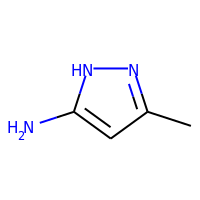
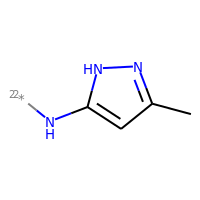
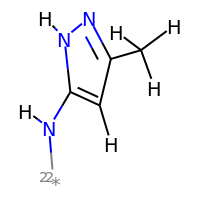
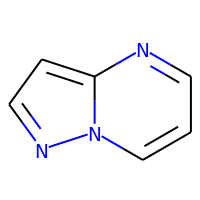
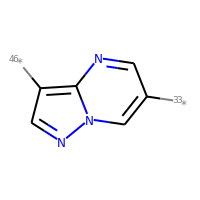
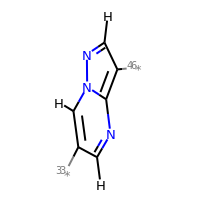
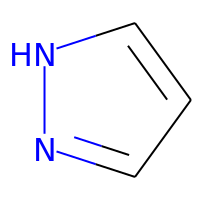
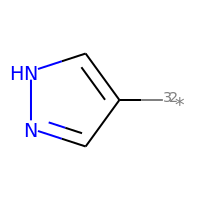
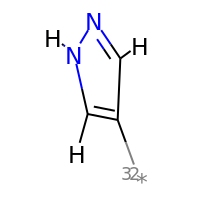
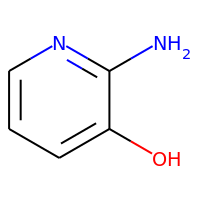
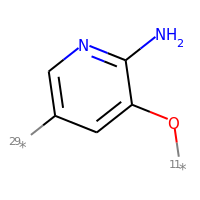
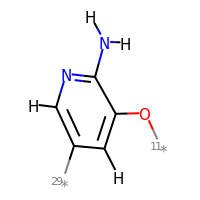
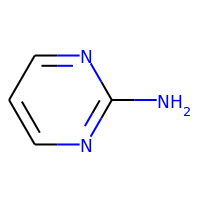
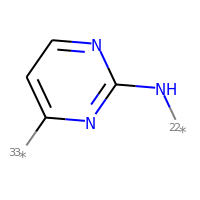
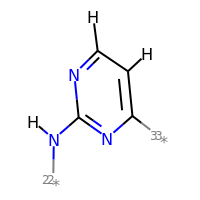
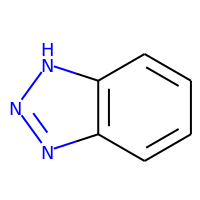
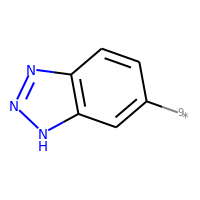
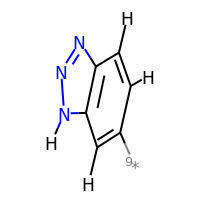
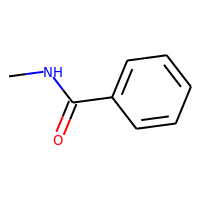
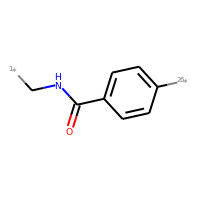
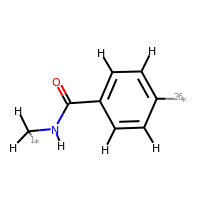
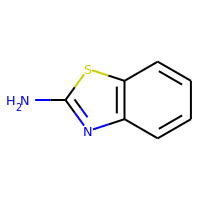
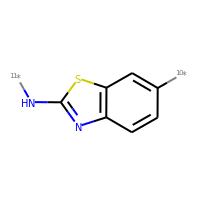
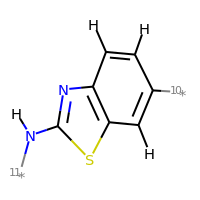
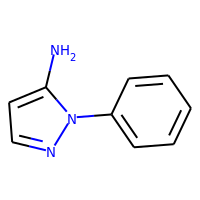
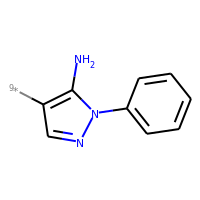
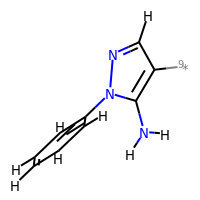
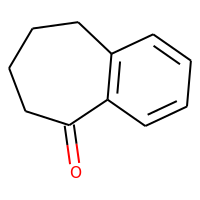
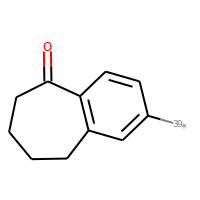
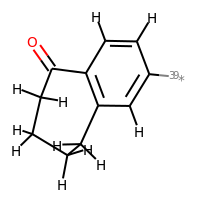

In [23]:
fragment_library_filtered['AP']

## 3. Get matching fragment pairs and check conditions

using https://github.com/volkamerlab/KinaseFocusedFragmentLibrary/blob/b7e684c26f75efffc2a9ba2383c9027cdd4c29a3/kinase_focused_fragment_library/recombination/cli.py#L205

In [24]:
from kinase_focused_fragment_library.recombination.classes_meta import \
    Combination, PermutationStep, Fragment, Compound, Port
from collections import deque 

from kinase_focused_fragment_library.recombination.brics_rules import is_brics_bond
from rdkit.Chem.PropertyMol import PropertyMol
from rdkit.Chem.Draw import IPythonConsole
from functools import reduce
from kinase_focused_fragment_library.recombination.get_tuple import get_tuple
from kinase_focused_fragment_library.recombination.process_results import \
    results_to_file, add_to_results, process_result
from kinase_focused_fragment_library.recombination.brics_rules import is_brics_bond

In [25]:
def get_valid_pairs(fragment_library):

    results = []
    data = {}  # (Fragments)
    queue = deque()  # queue containing fragmentation sites to be processed (PermutationSteps containing Compounds)

    frag_set = set()  # only used in initialization for avoiding duplicates in fragment data set (smiles & dummy atoms)
    frags_in_queue = set()  # set containing all fragments that have once been in the queue (Combinations)
    fragment_ids = []
    #iterate through fragments
    #save index and dummy atoms, bonds etc
    for subpocket in fragment_library.keys():
        fragments = []
        for i, row in fragment_library[subpocket].iterrows():
            #get fragment and connecting subpockets
            fragment = row['ROMol_original']
            fragment = Chem.RemoveHs(fragment)
            frag_id = f'{subpocket}_{i}'
            #connections = row['connections']
            
            # store unique atom identifiers
            for a, atom in enumerate(fragment.GetAtoms()):
                frag_atom_id = f'{subpocket}_{a}'
                atom.SetProp('frag_atom_id', frag_atom_id)
                
            # get all dummy atoms of this fragment except the ones corresponding to the X pool
            dummy_atoms = [a for a in fragment.GetAtoms() if a.GetSymbol() == '*' and not a.GetProp('subpocket').startswith('X')]
            if not dummy_atoms:
                continue
            
            frag_smiles, dummy_set = get_tuple(fragment, dummy_atoms)
            # check if this exact fragment has already been found
            if (frag_smiles, dummy_set) in frag_set:
                continue
            # if not, add this fragment to set of fragments
            frag_set.add((frag_smiles, dummy_set))

            # create dummy atom objects
            ports = [Port(atom_id=dummy.GetProp('frag_atom_id'), subpocket=subpocket, neighboring_subpocket=dummy.GetProp('subpocket'),
                          bond_type=fragment.GetBondBetweenAtoms(dummy.GetIdx(), dummy.GetNeighbors()[0].GetIdx()).GetBondType(),
                          environment=dummy.GetNeighbors()[0].GetProp('environment'))
                     for dummy in dummy_atoms]   
            # add all dummy atoms of this fragment to the queue
            compound = Compound(frag_ids=[frag_id], subpockets=[subpocket], ports=ports, bonds=[])
            for dummy in dummy_atoms:
                ps = PermutationStep(mol=compound, dummy=dummy.GetProp('frag_atom_id'), subpocket=subpocket,
                                         neighboring_subpocket=dummy.GetProp('subpocket'))
                queue.append(ps)
            combo = Combination(frag_ids=frozenset([frag_id]))
            frags_in_queue.add(combo)
            
            # store fragment in constant data set
            fragment = Fragment(frag_id=frag_id, subpocket=subpocket, ports=ports)
            fragments.append(fragment)
        data[subpocket] = fragments
        
    n_frags = len(frag_set)

    print('Number of fragments: ', n_frags)
    
    return data, queue

In [26]:
def checkvalid(data, fragment_library):
    matches = []
    environments = []
    bond_types = []
    for subpocket in fragment_library.keys():
        for fragment in data[subpocket]:
            fragment_id1 = fragment.frag_id
            for i in range(0,len(fragment.ports)):
                neighbor = fragment.ports[i].neighboring_subpocket
                bond_type = fragment.ports[i].bond_type
                environment = fragment.ports[i].environment
                match = []
                for frag2 in data[neighbor]:
                    fragment_id2 = frag2.frag_id              
                    for i in range(0,len(frag2.ports)): 
                        #check environment type, subpocket, bond type
                        environment_match = is_brics_bond(environment, frag2.ports[i].environment)
                        if frag2.ports[i].neighboring_subpocket == subpocket and neighbor ==  frag2.ports[i].subpocket and frag2.ports[i].bond_type == bond_type and environment_match:
                            match.append([fragment_id1, fragment_id2])

                            
                matches.append(match)
    return matches  

In [27]:
res, queue = get_valid_pairs(fragment_library_filtered)

Number of fragments:  487


In [28]:
valids = checkvalid(res, fragment_library_filtered)

In [29]:
queue[0] #not sure if I need queue

In [30]:
valids[0]

[['AP_0', 'SE_0'],
 ['AP_0', 'SE_2'],
 ['AP_0', 'SE_3'],
 ['AP_0', 'SE_4'],
 ['AP_0', 'SE_5'],
 ['AP_0', 'SE_6'],
 ['AP_0', 'SE_7'],
 ['AP_0', 'SE_8'],
 ['AP_0', 'SE_9'],
 ['AP_0', 'SE_10'],
 ['AP_0', 'SE_11'],
 ['AP_0', 'SE_12'],
 ['AP_0', 'SE_13'],
 ['AP_0', 'SE_15'],
 ['AP_0', 'SE_16'],
 ['AP_0', 'SE_17'],
 ['AP_0', 'SE_18'],
 ['AP_0', 'SE_19'],
 ['AP_0', 'SE_21'],
 ['AP_0', 'SE_23'],
 ['AP_0', 'SE_24'],
 ['AP_0', 'SE_25'],
 ['AP_0', 'SE_27'],
 ['AP_0', 'SE_28'],
 ['AP_0', 'SE_29'],
 ['AP_0', 'SE_30'],
 ['AP_0', 'SE_31'],
 ['AP_0', 'SE_33'],
 ['AP_0', 'SE_37'],
 ['AP_0', 'SE_38'],
 ['AP_0', 'SE_41'],
 ['AP_0', 'SE_45'],
 ['AP_0', 'SE_46'],
 ['AP_0', 'SE_48'],
 ['AP_0', 'SE_49'],
 ['AP_0', 'SE_50'],
 ['AP_0', 'SE_52'],
 ['AP_0', 'SE_53'],
 ['AP_0', 'SE_54'],
 ['AP_0', 'SE_55'],
 ['AP_0', 'SE_56'],
 ['AP_0', 'SE_57'],
 ['AP_0', 'SE_58'],
 ['AP_0', 'SE_59'],
 ['AP_0', 'SE_64'],
 ['AP_0', 'SE_65'],
 ['AP_0', 'SE_66'],
 ['AP_0', 'SE_67'],
 ['AP_0', 'SE_68'],
 ['AP_0', 'SE_70'],
 ['AP_0',

## trying recombination
something not correct...check it

In [38]:
def recomb (valids, fragment_library_filtered):
    ligands = []
    for valid_list in valids:
        for valid in valid_list:
            #print(valid)  #['AP_0', 'SE_0']
            fragments = []
            for fragment in valid:
                #get subpocket and fragment index in pocket
                subpocket = fragment.split("_")[0]
                fragment_index = int(fragment.split("_")[1])
                fragment = fragment_library_filtered[subpocket]["ROMol_original"][fragment_index]
                
                # Store unique atom identifiers in original molecule (important for recombined ligand construction based on atom IDs)
                fragment = Chem.RemoveHs(fragment)
                for i, atom in enumerate(fragment.GetAtoms()):
                    fragment_atom_id = f"{subpocket}_{i}"
                    atom.SetProp("fragment_atom_id", fragment_atom_id)
                    atom.SetProp("fragment_id", fragment.GetProp("complex_pdb"))
                fragment = PropertyMol(fragment)

                # Append fragment to list of fragments
                fragments.append(fragment)
            # Combine fragments using map-reduce model
            combo = reduce(Chem.CombineMols, fragments)

            bonds_matching = True
            ed_combo = Chem.EditableMol(combo)
            replaced_dummies = []

            atoms = combo.GetAtoms()
            #print(Chem.Mol(combo))
            
            #print(valid[0]+ " + " + valid[1])
            try:
                dummy_1 = next(atom for atom in combo.GetAtoms() if atom.GetProp("fragment_atom_id") == valid[0])
                dummy_2 = next(atom for atom in combo.GetAtoms() if atom.GetProp("fragment_atom_id") == valid[1])
            except:
                continue
            atom_1 = dummy_1.GetNeighbors()[0]
            atom_2 = dummy_2.GetNeighbors()[0]

            # check bond types
            bond_type_1 = combo.GetBondBetweenAtoms(dummy_1.GetIdx(), atom_1.GetIdx()).GetBondType()
            bond_type_2 = combo.GetBondBetweenAtoms(dummy_2.GetIdx(), atom_2.GetIdx()).GetBondType()
            if bond_type_1 != bond_type_2:
                bonds_matching = False
                continue

            ed_combo.AddBond(atom_1.GetIdx(), atom_2.GetIdx(), order=bond_type_1)

            replaced_dummies.extend([dummy_1.GetIdx(), dummy_2.GetIdx()])   
            # Do not construct this ligand if bond types are not matching
            if not bonds_matching:
                print('Bonds are not matching')
                continue

            # Remove replaced dummy atoms
            replaced_dummies.sort(reverse=True)
            for dummy in replaced_dummies:
                ed_combo.RemoveAtom(dummy)

            ligand = ed_combo.GetMol()

            # Replace remaining dummy atoms with hydrogens
            du = Chem.MolFromSmiles("*")
            h = Chem.MolFromSmiles("[H]", sanitize=False)
            ligand = AllChem.ReplaceSubstructs(ligand, du, h, replaceAll=True)[0]
            try:
                ligand = Chem.RemoveHs(ligand)
            except ValueError:
                #print(Chem.MolToSmiles(ligand))
                continue

            # Clear properties
            for prop in ligand.GetPropNames():
                ligand.ClearProp(prop)
            for atom in ligand.GetAtoms():
                atom.ClearProp("fragment_atom_id")

            # Generate 2D coordinates
            AllChem.Compute2DCoords(ligand)
            ligands.append(ligand)
        
    return ligands

In [39]:
recombs = recomb(valids, fragment_library_filtered)

,0
0,
1,
2,
3,

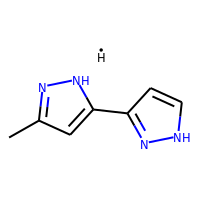
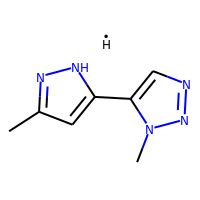
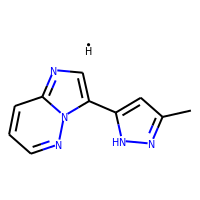
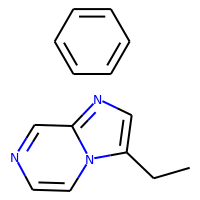

In [40]:
pd.DataFrame(recombs[1:5])

In [88]:
ligands = []
for valid in valids:
    for pair in valid:
        print(pair)  #['AP_0', 'SE_0']
        fragments = []
        for fragment_id in pair:

            # Get subpocket and fragment index in subpocket
            subpocket = fragment_id.split("_")[0]
            fragment_index = int(fragment_id.split("_")[1])
            fragment = fragment_library[subpocket]["ROMol_original"][fragment_index]

            # Store unique atom identifiers in original molecule (important for recombined ligand construction based on atom IDs)
            fragment = Chem.RemoveHs(fragment)
            for i, atom in enumerate(fragment.GetAtoms()):
                fragment_atom_id = f"{subpocket}_{i}"
                atom.SetProp("fragment_atom_id", fragment_atom_id)
                atom.SetProp("fragment_id", fragment.GetProp("complex_pdb"))
            fragment = PropertyMol(fragment)

            # Append fragment to list of fragments
            fragments.append(fragment)
        
        # Combine fragments using map-reduce model
        combo = reduce(Chem.CombineMols, fragments)

        bonds_matching = True
        ed_combo = Chem.EditableMol(combo)
        replaced_dummies = []

        atoms = combo.GetAtoms() 
        
        #todo: get position of dummy atoms
        dummy_1 = next(
            atom for atom in combo.GetAtoms() if not atom.GetProp("fragment_atom_id") == bond[0]
        )
        dummy_2 = next(
            atom for atom in combo.GetAtoms() if not atom.GetProp("fragment_atom_id") == bond[1]
        )
        atom_1 = dummy_1.GetNeighbors()[0]
        atom_2 = dummy_2.GetNeighbors()[0]
        
        # check bond types
        bond_type_1 = combo.GetBondBetweenAtoms(dummy_1.GetIdx(), atom_1.GetIdx()).GetBondType()
        bond_type_2 = combo.GetBondBetweenAtoms(dummy_2.GetIdx(), atom_2.GetIdx()).GetBondType()
        if bond_type_1 != bond_type_2:
            bonds_matching = False
            break

        ed_combo.AddBond(atom_1.GetIdx(), atom_2.GetIdx(), order=bond_type_1)

        replaced_dummies.extend([dummy_1.GetIdx(), dummy_2.GetIdx()])
        
        # Do not construct this ligand if bond types are not matching
        if not bonds_matching:
            #return
            break

        # Remove replaced dummy atoms
        replaced_dummies.sort(reverse=True)
        for dummy in replaced_dummies:
            ed_combo.RemoveAtom(dummy)

        ligand = ed_combo.GetMol()

        # Replace remaining dummy atoms with hydrogens
        du = Chem.MolFromSmiles("*")
        h = Chem.MolFromSmiles("[H]", sanitize=False)
        ligand = AllChem.ReplaceSubstructs(ligand, du, h, replaceAll=True)[0]
        try:
            ligand = Chem.RemoveHs(ligand)
        except ValueError:
            print(Chem.MolToSmiles(ligand))
            #return
            break

        # Clear properties
        for prop in ligand.GetPropNames():
            ligand.ClearProp(prop)
        for atom in ligand.GetAtoms():
            atom.ClearProp("fragment_atom_id")

        # Generate 2D coordinates
        AllChem.Compute2DCoords(ligand)

        ligands.append(ligand)

['AP_0', 'SE_0']


RuntimeError: Pre-condition Violation
	bond already exists
	Violation occurred on line 302 in file Code/GraphMol/RWMol.cpp
	Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
	RDKIT: 2020.03.3
	BOOST: 1_72
